## Imports

In [101]:
import tensorflow as tf
import sys
import sklearn as sk
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as pltLib
import sklearn.feature_extraction.text as sk_text
from scipy.stats import zscore

from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
import io
import requests
from sklearn import metrics

## Useful Functions for Pre-processing data used for Tensorflow

In [14]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

## Environment Version Checking

In [15]:
print("Python {}".format(sys.version)) # Best for data science and machine learning/deep learning
print("Pandas {}".format(pd.__version__)) # Used for data manipulation
print("Scikit-Learn {}".format(sk.__version__)) # Most popular machine learning library
print()
print("Tensor Flow Version: {}".format(tf.__version__)) # Google's Machine Learning Library
print("Keras Version: {}".format(tf.keras.__version__)) # Used for
print()
print("Numpy Version: {}".format(np.__version__)) # Used for memory efficiency and speed with matrices and big data
print("Scipy Version: {}".format(sp.__version__)) # It provides many user-friendly and efficient numerical routines such as stats, numerical integration and optimization.
print("Matplotlib Version: {}".format(pltLib.__version__)) # Used for showing visuals of data

Python 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.4
Scikit-Learn 0.24.1

Tensor Flow Version: 2.3.0
Keras Version: 2.4.0

Numpy Version: 1.20.1
Scipy Version: 1.6.2
Matplotlib Version: 3.3.4


# Stage 1: Pre-processing

## Loading business json into business dataframe

In [16]:
#!!! import yelp data and assign that data to a dataframe
PROJECT_DATASET_PATH = 'E:\Development\CodingProjects\CSC180-Intelligent-Systems\project_1\yelp_dataset\yelp_dataset~\\'
#!!! this json file is the 'records' type of JSON. Columns is the default orientation value.
businessJSON = 'yelp_academic_dataset_business.json'
# path to file, lines = true means that data is on separate lines in the file, and the way its oriented is in records
df_business = pd.read_json(PROJECT_DATASET_PATH + businessJSON, lines = 'true', orient = 'records')

In [17]:
print(df_business.head())

              business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.9555

## Filter out businesses with less than 20 reviews in the business dataframe

In [18]:
filtered_business_df = df_business[df_business['review_count'] >= 20]

In [19]:
print(filtered_business_df.head())

               business_id                  name               address  \
2   tUFrWirKiKi_TAnsVWINQQ                Target  5255 E Broadway Blvd   
3   MTSW4McQd7CbVtyjqoe9mw    St Honore Pastries           935 Race St   
12  il_Ro8jwPlHresjw9EGmBg               Denny's          8901 US 31 S   
14  0bPLkL0QhhPO5kt1_EXmNQ  Zio's Italian Market         2575 E Bay Dr   
15  MUTTqe8uqyMdBl186RmNeA              Tuna Bar           205 Race St   

            city state postal_code   latitude   longitude  stars  \
2         Tucson    AZ       85711  32.223236 -110.880452    3.5   
3   Philadelphia    PA       19107  39.955505  -75.155564    4.0   
12  Indianapolis    IN       46227  39.637133  -86.127217    2.5   
14         Largo    FL       33771  27.916116  -82.760461    4.5   
15  Philadelphia    PA       19106  39.953949  -75.143226    4.0   

    review_count  is_open                                         attributes  \
2             22        0  {'BikeParking': 'True', 'BusinessAccept

## Creating data frame for reviews

In [20]:
reviewFileName = "yelp_academic_dataset_review.json"
df_review = pd.read_json(PROJECT_DATASET_PATH + reviewFileName, lines = 'true', orient = 'records')

## Grouping the review records by business_id, along with relative text. We could add more if we'd like.

In [21]:
df_review_agg = df_review.groupby(['business_id'])['text'].sum()

In [22]:
print(df_review_agg.head())

business_id
---kPU91CF4Lq2-WlRu9Lw    Ate here for the 1st time on Saturday 08/07/20...
--0iUa4sNDFiZFrAdIWhZQ    Very good San Salvadorian place ! Authentic an...
--30_8IhuyMHbSOcNWd6DQ    We stopped going to Action Karate in December ...
--7PUidqRWpRSpXebiyxTg    This place is disgusting, and proof that Edmon...
--7jw19RH9JKXgFohspgQw    This is the best dentist in the area, hands do...
Name: text, dtype: object


## Merging reviews that are aggregated, with businesses containing 20 reviews or more.

In [156]:
merged_dfs = pd.merge(df_review_agg, filtered_business_df, on='business_id', how='inner')

In [157]:
print(merged_dfs.head())

              business_id                                               text  \
0  ---kPU91CF4Lq2-WlRu9Lw  Ate here for the 1st time on Saturday 08/07/20...   
1  --8IbOsAAxjKRoYsBFL-PA  Took me for 40 bucks through grubhub, no call ...   
2  --9osgUCSDUWUkoTLdvYhQ  I loved this!!!! I was set up on a blind date ...   
3  --ARBQr1WMsTWiwOKOj-FQ  What a great neighborhood place to wine it up....   
4  --FcbSxK1AoEtEAxOgBaCw  This is my go to car wash establishment. Today...   

                       name               address             city state  \
0         Frankie's Raw Bar      4903 State Rd 54  New Port Richey    FL   
1  The Original Italian Pie        4706 Paris Ave         Gentilly    LA   
2          Will You Escape?      2577 N First Ave           Tucson    AZ   
3           Traveling Corks  3219 Bay To Bay Blvd            Tampa    FL   
4          Victory Car Wash         3820 US-301 S        Riverview    FL   

  postal_code   latitude   longitude  stars  review_count  is_

## Transforming text into a sparse matrix, then converting that matrix into a regular array.

In [145]:
# TF-IDF Vectorizer : Transforms text into a 'sparse matrix' where rows are text and columns are words, values are the TF-IDF values.
vectorizer = sk_text.TfidfVectorizer(min_df=1, max_features=1000)

In [146]:
matrix = vectorizer.fit_transform(merged_dfs['text'])
print(type(matrix))

<class 'scipy.sparse.csr.csr_matrix'>


In [147]:
matrix = matrix.toarray()
print(type(matrix)) # Matrix converted successfully!
matrix.shape
print(matrix)

<class 'numpy.ndarray'>
[[0.         0.00798992 0.         ... 0.         0.01545267 0.        ]
 [0.00766663 0.01545444 0.         ... 0.00727874 0.         0.00825474]
 [0.         0.         0.         ... 0.00644793 0.         0.        ]
 ...
 [0.00769936 0.00517348 0.         ... 0.         0.         0.        ]
 [0.         0.01577598 0.         ... 0.         0.         0.01516766]
 [0.04261626 0.00572708 0.00885671 ... 0.         0.         0.        ]]


### Showing my vectorizer's feature names which will be column labels in a dataframe soon

In [148]:
print(vectorizer.get_feature_names())
print(len(vectorizer.get_feature_names()))

['00', '10', '100', '11', '12', '15', '20', '25', '30', '40', '45', '50', 'able', 'about', 'above', 'absolutely', 'accommodating', 'across', 'actually', 'add', 'added', 'addition', 'after', 'afternoon', 'again', 'ago', 'ahead', 'all', 'almost', 'along', 'already', 'also', 'although', 'always', 'am', 'amazing', 'ambiance', 'amount', 'an', 'and', 'another', 'any', 'anyone', 'anything', 'anyway', 'anywhere', 'appetizer', 'appetizers', 'appointment', 'are', 'area', 'aren', 'around', 'arrived', 'as', 'ask', 'asked', 'asking', 'at', 'ate', 'atmosphere', 'attention', 'attentive', 'attitude', 'authentic', 'available', 'average', 'avocado', 'away', 'awesome', 'awful', 'back', 'bacon', 'bad', 'baked', 'bar', 'bartender', 'based', 'basically', 'bathroom', 'bbq', 'be', 'beach', 'beans', 'beautiful', 'because', 'bed', 'beef', 'been', 'beer', 'beers', 'before', 'behind', 'being', 'believe', 'best', 'better', 'between', 'beyond', 'big', 'bill', 'birthday', 'bit', 'bite', 'black', 'bland', 'both', 'bo


1000


## Drop other columns that we don't need for now
 Reasoning is that latitude and longitude don't have a correlation with how good a business is. It's mainly about the product, which is food. <br />
 Categories doesn't tell me how good the business is. <br />
 I will assume that Postal code, state, city, address, name, business_id, if it's open, its hours, are insignificant. <br />
 **For future improvements, maybe we can include review reactions.**
 

In [158]:
merged_dfs_before = merged_dfs.copy()
merged_dfs_before

,business_id,text,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,---kPU91CF4Lq2-WlRu9Lw,Ate here for the 1st time on Saturday 08/07/20...,Frankie's Raw Bar,4903 State Rd 54,New Port Richey,FL,34652,28.217288,-82.733344,4.5,24,1,"{'Alcohol': 'u'none'', 'OutdoorSeating': 'True...","Seafood, Restaurants, Latin American, Food, Fo...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
1,--8IbOsAAxjKRoYsBFL-PA,"Took me for 40 bucks through grubhub, no call ...",The Original Italian Pie,4706 Paris Ave,Gentilly,LA,70122,30.006341,-90.074523,3.0,27,0,"{'RestaurantsDelivery': 'True', 'RestaurantsRe...","Food, Restaurants, Italian","{'Monday': '11:0-21:30', 'Tuesday': '11:0-21:3..."
2,--9osgUCSDUWUkoTLdvYhQ,I loved this!!!! I was set up on a blind date ...,Will You Escape?,2577 N First Ave,Tucson,AZ,85719,32.253677,-110.961772,5.0,29,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Active Life, Challenge Courses, Escape Games","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'..."
3,--ARBQr1WMsTWiwOKOj-FQ,What a great neighborhood place to wine it up....,Traveling Corks,3219 Bay To Bay Blvd,Tampa,FL,33629,27.919884,-82.495936,4.5,23,0,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Wine Bars, Nightlife, Bars","{'Tuesday': '15:0-22:0', 'Wednesday': '15:0-22..."
4,--FcbSxK1AoEtEAxOgBaCw,This is my go to car wash establishment. Today...,Victory Car Wash,3820 US-301 S,Riverview,FL,33578,27.914364,-82.347753,3.5,40,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Car Wash, Automotive",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61914,zzbZtgPYZS8sTIWQH6DwEw,Last night was my first time over at F&M on Tc...,F & M Patio Bar,4841 Tchoupitoulas St,New Orleans,LA,70115,29.916857,-90.106974,3.0,86,1,"{'RestaurantsReservations': 'False', 'BikePark...","Food, American (Traditional), Nightlife, Resta...","{'Monday': '19:0-4:0', 'Tuesday': '19:0-4:0', ..."
61915,zzbpcMZXHoZxUr9JZdH6wg,I went here for the HydroFacial. I have gotten...,Eden Medical Spa,129 Pennsylvania Ave,Wayne,PA,19087,40.046115,-75.384733,1.5,22,1,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Laser Hair Removal, Beauty & Spas, Skin Care, ...","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."
61916,zzfj1-iPfw0cwnOjY0yUgA,I recently stopped here for lunch.I had debs c...,Ruby's Kitchen,559 Stewarts Ferry Pike,Nashville,TN,37214,36.158037,-86.634973,3.0,24,0,"{'Alcohol': 'u'none'', 'Ambience': '{'romantic...","Breakfast & Brunch, Burgers, American (Traditi...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-20:0', ..."
61917,zzjFdJwXuxBOGe9JeY_EMw,Went in for lunch and tried the jerk chicken a...,Taste of the Islands,1500 Powell St,Norristown,PA,19401,40.125572,-75.333395,4.0,47,1,"{'RestaurantsTableService': 'False', 'Business...","Caribbean, Restaurants","{'Monday': '11:30-20:0', 'Tuesday': '11:30-20:..."


In [159]:
merged_dfs.drop(['business_id', 'name', 'address', 'city', 'state',
                 'postal_code','latitude', 'longitude', 'categories',
                 'is_open', 'attributes', 'hours'], axis=1, inplace=True)
merged_dfs.head()

,text,stars,review_count
0,Ate here for the 1st time on Saturday 08/07/20...,4.5,24
1,"Took me for 40 bucks through grubhub, no call ...",3.0,27
2,I loved this!!!! I was set up on a blind date ...,5.0,29
3,What a great neighborhood place to wine it up....,4.5,23
4,This is my go to car wash establishment. Today...,3.5,40


In [160]:
encode_numeric_zscore(merged_dfs, 'review_count')

In [161]:
merged_dfs.head()

,text,stars,review_count
0,Ate here for the 1st time on Saturday 08/07/20...,4.5,-0.402919
1,"Took me for 40 bucks through grubhub, no call ...",3.0,-0.385956
2,I loved this!!!! I was set up on a blind date ...,5.0,-0.374648
3,What a great neighborhood place to wine it up....,4.5,-0.408573
4,This is my go to car wash establishment. Today...,3.5,-0.312452


## Drop text column

In [162]:
merged_dfs.drop(['text'], axis=1, inplace=True)
merged_dfs

,stars,review_count
0,4.5,-0.402919
1,3.0,-0.385956
2,5.0,-0.374648
3,4.5,-0.408573
4,3.5,-0.312452
...,...,...
61914,3.0,-0.052359
61915,1.5,-0.414227
61916,3.0,-0.402919
61917,4.0,-0.272873


## Rename output column 'stars' to something more unique.

In [163]:
merged_dfs = merged_dfs.rename(columns = {'stars' : 'stars_rating'})
merged_dfs

,stars_rating,review_count
0,4.5,-0.402919
1,3.0,-0.385956
2,5.0,-0.374648
3,4.5,-0.408573
4,3.5,-0.312452
...,...,...
61914,3.0,-0.052359
61915,1.5,-0.414227
61916,3.0,-0.402919
61917,4.0,-0.272873


## Converting the sparse matrix with TF-IDF values into a dataframe first.

In [34]:
matrix_df = pd.DataFrame(matrix, columns = vectorizer.get_feature_names())

## Adding the converted dataframe's columns to the already merged dataframe.  

In [35]:
concatenated_matrix_df = pd.concat([matrix_df, merged_dfs], axis=1)

In [36]:
concatenated_matrix_df

,00,10,100,11,12,15,20,25,30,40,...,yes,yet,you,young,your,yourself,yum,yummy,stars_rating,review_count
0,0.000000,0.007990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.035253,0.011895,0.021378,0.000000,0.015453,0.000000,4.5,-0.402919
1,0.007667,0.015454,0.000000,0.000000,0.000000,0.018249,0.005864,0.015549,0.005870,0.008145,...,0.000000,0.006131,0.077280,0.000000,0.013783,0.007279,0.000000,0.008255,3.0,-0.385956
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005194,0.000000,0.010399,0.000000,...,0.000000,0.005432,0.165107,0.000000,0.016280,0.006448,0.000000,0.000000,5.0,-0.374648
3,0.000000,0.014528,0.000000,0.000000,0.000000,0.000000,0.008268,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.096152,0.000000,0.032393,0.000000,0.000000,0.000000,4.5,-0.408573
4,0.000000,0.010428,0.000000,0.005512,0.000000,0.020522,0.003956,0.000000,0.000000,0.000000,...,0.004392,0.008274,0.088952,0.000000,0.058901,0.000000,0.000000,0.000000,3.5,-0.312452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61914,0.002084,0.002800,0.000000,0.000000,0.001982,0.006613,0.009562,0.008452,0.004786,0.004427,...,0.007076,0.006666,0.214982,0.012507,0.046202,0.007913,0.000000,0.000000,3.0,-0.052359
61915,0.000000,0.000000,0.000000,0.008525,0.015223,0.000000,0.006119,0.000000,0.012251,0.000000,...,0.000000,0.006399,0.113856,0.000000,0.038357,0.007596,0.000000,0.000000,1.5,-0.414227
61916,0.007699,0.005173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005895,0.008179,...,0.000000,0.000000,0.022826,0.007702,0.013842,0.000000,0.000000,0.000000,3.0,-0.402919
61917,0.000000,0.015776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009977,...,0.000000,0.000000,0.069607,0.014092,0.025326,0.000000,0.000000,0.015168,4.0,-0.272873


# Stage 2: Tensorflow fitting/training

# Tweaking parameters
### • Activation: relu, sigmoid, tanh
### • Number of layers and neuron count for each layer
### • Optimizer: adam and sgd

# 1) Testing relu, sigmoid, and tanh activation functions

In [59]:
def activationTest(activation_list, df):
    # Defining model checkpoint outside of the loop
    checkpointer = ModelCheckpoint(filepath='dnn/best_weights.hdf5', verbose=0, save_best_only=True) # save best model
    
    x,y = to_xy(df, "stars_rating")
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

    for i in range (5):
        print()
        print("Iteration: ", i)

        # Building neural network
        model_sequential = Sequential()
        model_sequential.add(Dense(10, input_dim=x.shape[1], activation=activation_list[0])) # Input layer
        model_sequential.add(Dense(5, activation=activation_list[1])) # Hidden layer 1
        model_sequential.add(Dense(1, activation=activation_list[2])) # Output layer

        # If this were classification, we'd use a softmax activation
        model_sequential.compile(loss='mean_squared_error', optimizer='adam')

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
        # Patience = number of epochs with no improvements which training will be stopped.

        model_sequential.fit(x_train, y_train, validation_data=(x_test,y_test),
                             batch_size=32, callbacks=[monitor, checkpointer], verbose=0, epochs=100)

        
    model_sequential.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    prediction = model_sequential.predict(x_test)

    # Measuring RMSE
    RMSE_score = np.sqrt(metrics.mean_squared_error(prediction, y_test))
    print("Activations used in order: {}".format(activation_list))
    print("Final score (RMSE): {}".format(RMSE_score))
    # Plot the lift chart
    # Sort set to true to see how our model predicts it from least to greatest
    chart_regression(prediction.flatten(),y_test, sort=True)

    return (activation_list, RMSE_score)
    

# WARNING: Running the code below will take around 15 min to complete.


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('relu', 'relu', 'relu')
Final score (RMSE): 0.2585594058036804


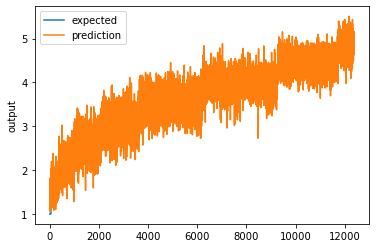


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('relu', 'relu', 'sigmoid')
Final score (RMSE): 2.7490785121917725


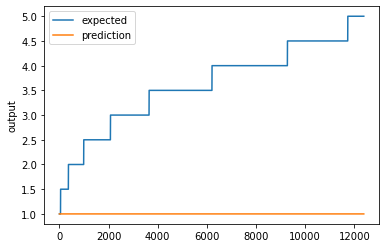


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('relu', 'relu', 'tanh')
Final score (RMSE): 2.7490785121917725


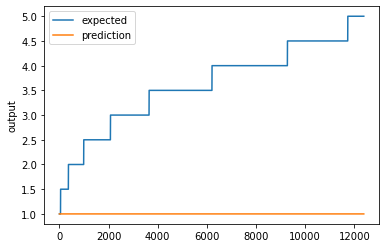


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('relu', 'sigmoid', 'relu')
Final score (RMSE): 0.2514468729496002


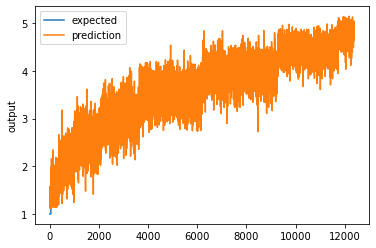


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('relu', 'sigmoid', 'sigmoid')
Final score (RMSE): 2.749079942703247


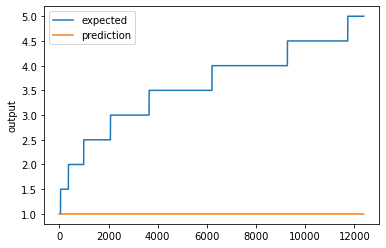


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('relu', 'sigmoid', 'tanh')
Final score (RMSE): 2.7490789890289307


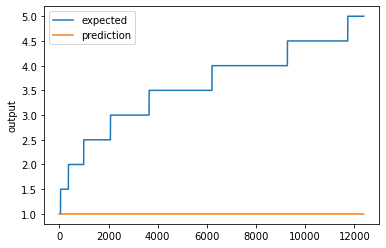


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('relu', 'tanh', 'relu')
Final score (RMSE): 0.25265178084373474


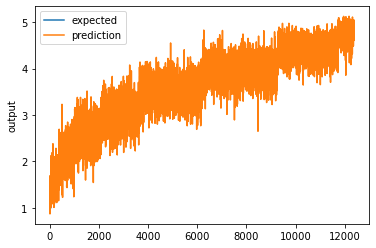


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('relu', 'tanh', 'sigmoid')
Final score (RMSE): 2.749079704284668


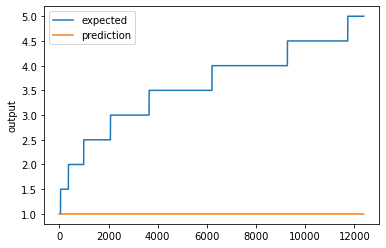


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('relu', 'tanh', 'tanh')
Final score (RMSE): 2.7490785121917725


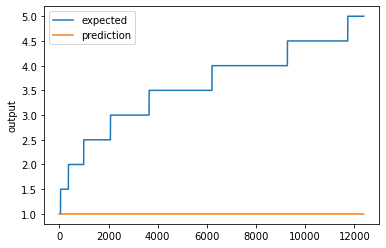


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('sigmoid', 'relu', 'relu')
Final score (RMSE): 0.2540408968925476


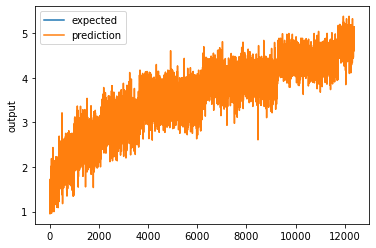


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('sigmoid', 'relu', 'sigmoid')
Final score (RMSE): 2.749079704284668


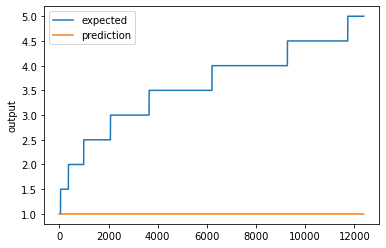


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('sigmoid', 'relu', 'tanh')
Final score (RMSE): 2.7490785121917725


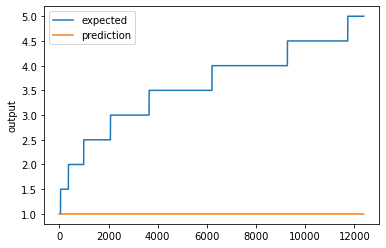


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('sigmoid', 'sigmoid', 'relu')
Final score (RMSE): 0.2524460554122925


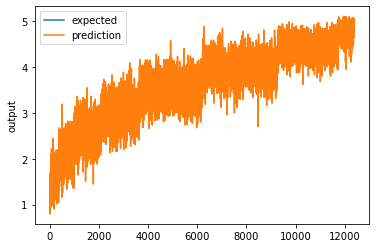


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('sigmoid', 'sigmoid', 'sigmoid')
Final score (RMSE): 2.749079942703247


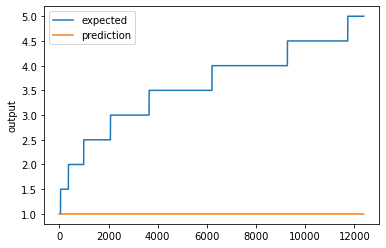


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('sigmoid', 'sigmoid', 'tanh')
Final score (RMSE): 2.749079704284668


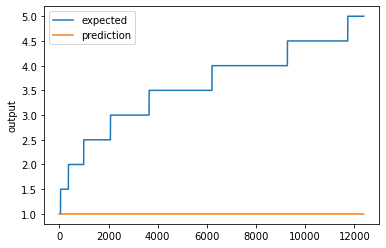


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('sigmoid', 'tanh', 'relu')
Final score (RMSE): 0.25138211250305176


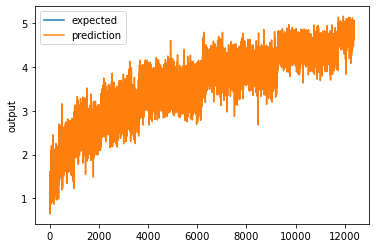


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('sigmoid', 'tanh', 'sigmoid')
Final score (RMSE): 2.749079942703247


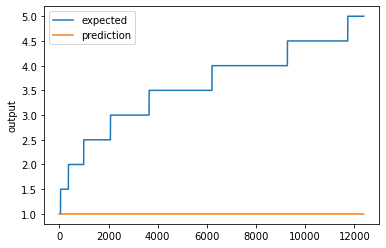


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('sigmoid', 'tanh', 'tanh')
Final score (RMSE): 2.7490785121917725


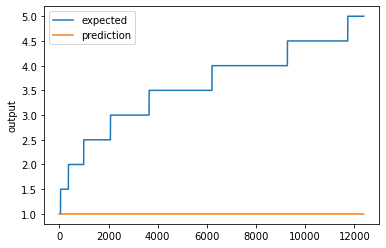


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('tanh', 'relu', 'relu')
Final score (RMSE): 0.25369834899902344


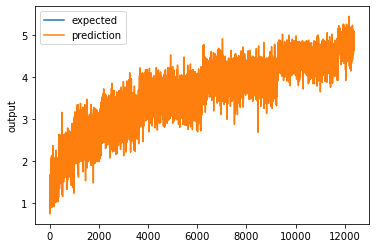


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('tanh', 'relu', 'sigmoid')
Final score (RMSE): 2.7490785121917725


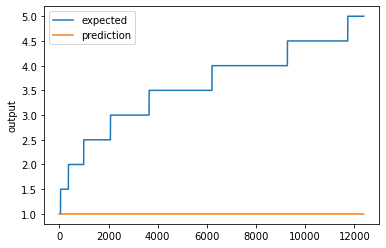


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('tanh', 'relu', 'tanh')
Final score (RMSE): 2.7490787506103516


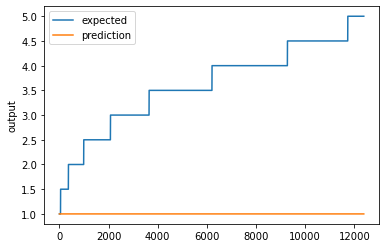


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('tanh', 'sigmoid', 'relu')
Final score (RMSE): 0.25312963128089905


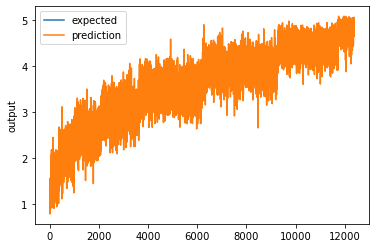


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('tanh', 'sigmoid', 'sigmoid')
Final score (RMSE): 2.749079942703247


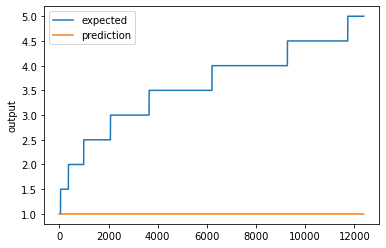


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('tanh', 'sigmoid', 'tanh')
Final score (RMSE): 2.749079465866089


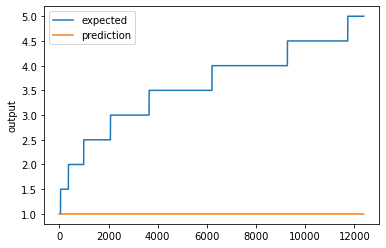


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('tanh', 'tanh', 'relu')
Final score (RMSE): 0.25023043155670166


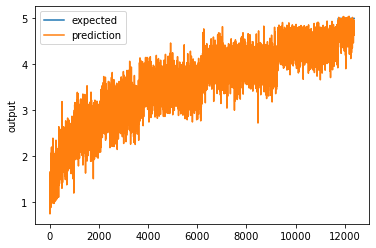


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('tanh', 'tanh', 'sigmoid')
Final score (RMSE): 2.749079704284668


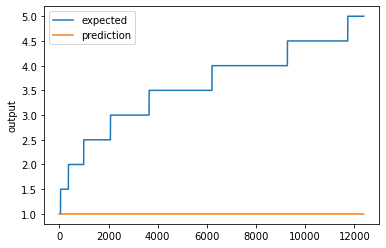


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Activations used in order: ('tanh', 'tanh', 'tanh')
Final score (RMSE): 2.7490785121917725


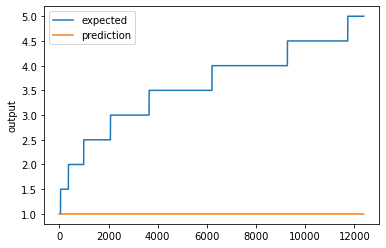

In [60]:
from itertools import product

results = []
activation_algorithms = ['relu', 'sigmoid', 'tanh']
for c in product(activation_algorithms, repeat = len(activation_algorithms)):
    results.append(c)
    
scores_with_activations = []

for activationTriplet in results:
    scores_with_activations.append(activationTest(activationTriplet, concatenated_matrix_df))
    


In [63]:
for x in scores_with_activations:
    print(str(x))

(('relu', 'relu', 'relu'), 0.2585594)
(('relu', 'relu', 'sigmoid'), 2.7490785)
(('relu', 'relu', 'tanh'), 2.7490785)
(('relu', 'sigmoid', 'relu'), 0.25144687)
(('relu', 'sigmoid', 'sigmoid'), 2.74908)
(('relu', 'sigmoid', 'tanh'), 2.749079)
(('relu', 'tanh', 'relu'), 0.25265178)
(('relu', 'tanh', 'sigmoid'), 2.7490797)
(('relu', 'tanh', 'tanh'), 2.7490785)
(('sigmoid', 'relu', 'relu'), 0.2540409)
(('sigmoid', 'relu', 'sigmoid'), 2.7490797)
(('sigmoid', 'relu', 'tanh'), 2.7490785)
(('sigmoid', 'sigmoid', 'relu'), 0.25244606)
(('sigmoid', 'sigmoid', 'sigmoid'), 2.74908)
(('sigmoid', 'sigmoid', 'tanh'), 2.7490797)
(('sigmoid', 'tanh', 'relu'), 0.2513821)
(('sigmoid', 'tanh', 'sigmoid'), 2.74908)
(('sigmoid', 'tanh', 'tanh'), 2.7490785)
(('tanh', 'relu', 'relu'), 0.25369835)
(('tanh', 'relu', 'sigmoid'), 2.7490785)
(('tanh', 'relu', 'tanh'), 2.7490788)
(('tanh', 'sigmoid', 'relu'), 0.25312963)
(('tanh', 'sigmoid', 'sigmoid'), 2.74908)
(('tanh', 'sigmoid', 'tanh'), 2.7490795)
(('tanh', 'tan

In [68]:
best_activationTriplets = []
for x in scores_with_activations:
    if x[0][2] == 'relu':    
        best_activationTriplets.append(x[0])

In [69]:
best_activationTriplets

[('relu', 'relu', 'relu'),
 ('relu', 'sigmoid', 'relu'),
 ('relu', 'tanh', 'relu'),
 ('sigmoid', 'relu', 'relu'),
 ('sigmoid', 'sigmoid', 'relu'),
 ('sigmoid', 'tanh', 'relu'),
 ('tanh', 'relu', 'relu'),
 ('tanh', 'sigmoid', 'relu'),
 ('tanh', 'tanh', 'relu')]

# 2) Neuron Capacity Test

# WARNING: Running the code below will take around 30 min to complete.

In [85]:
def neuron_capacity_test(input_capacity, hidden_capacity, df):
    # Defining model checkpoint outside of the loop
    checkpointer = ModelCheckpoint(filepath='dnn/best_weights.hdf5', verbose=0, save_best_only=True) # save best model
    
    x,y = to_xy(df, "stars_rating")
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

    for i in range (5):
        print()
        print("Iteration: ", i)

        # Building neural network
        model_sequential = Sequential()
        model_sequential.add(Dense(input_capacity, input_dim=x.shape[1], activation='relu')) # Input layer
        model_sequential.add(Dense(hidden_capacity, activation='relu')) # Hidden layer 1
        model_sequential.add(Dense(1, activation='relu')) # Output layer

        # If this were classification, we'd use a softmax activation
        model_sequential.compile(loss='mean_squared_error', optimizer='adam')

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
        # Patience = number of epochs with no improvements which training will be stopped.

        model_sequential.fit(x_train, y_train, validation_data=(x_test,y_test),
                             batch_size=32, callbacks=[monitor, checkpointer], verbose=0, epochs=100)

        
    model_sequential.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    prediction = model_sequential.predict(x_test)

    # Measuring RMSE
    RMSE_score = np.sqrt(metrics.mean_squared_error(prediction, y_test))
    print("Neuron Capacities: input: {} -> hidden: {}".format(input_capacity, hidden_capacity))
    print("Final score (RMSE): {}".format(RMSE_score))
    # Plot the lift chart
    # Sort set to true to see how our model predicts it from least to greatest
    chart_regression(prediction.flatten(),y_test, sort=True)

    return ((input_capacity, hidden_capacity), RMSE_score)
    

In [86]:
capacity_list = [(100, 100), (100, 50), (100, 25), (100, 12), (100, 6), (100, 3), (100, 1),
                (50, 100), (50, 50), (50, 25), (50, 12), (50, 6), (50, 3), (50, 1),
                (25, 100), (25, 50), (25, 25), (25, 12), (25, 6), (25, 3), (25, 1),
                (12, 100), (12, 50), (12, 25), (12, 12), (12, 6), (12, 3), (12, 1),
                (6, 100), (6, 50), (6, 25), (6, 12), (6, 6), (6, 3), (6, 1),
                (3, 100), (3, 50), (3, 25), (3, 12), (3, 6), (3, 3), (3, 1),
                (1, 100), (1, 50), (1, 25), (1, 12), (1, 6), (1, 3), (1, 1)]



Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 100 -> hidden: 100
Final score (RMSE): 0.25125768780708313


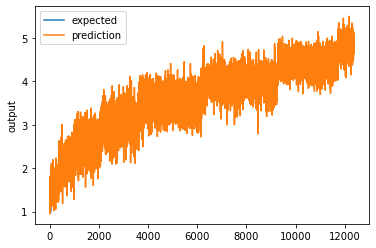


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 100 -> hidden: 50
Final score (RMSE): 0.2525220811367035


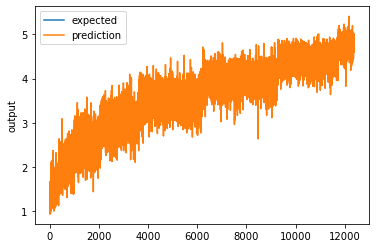


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 100 -> hidden: 25
Final score (RMSE): 0.25141558051109314


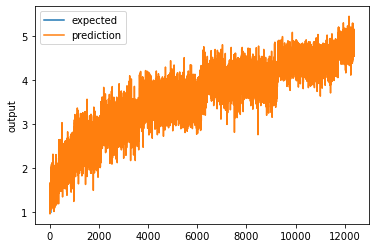


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 100 -> hidden: 12
Final score (RMSE): 0.2536633014678955


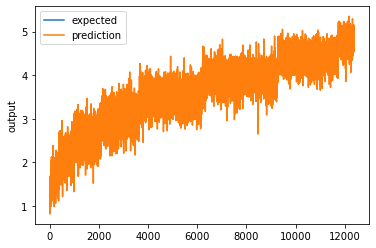


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 100 -> hidden: 6
Final score (RMSE): 0.2523024082183838


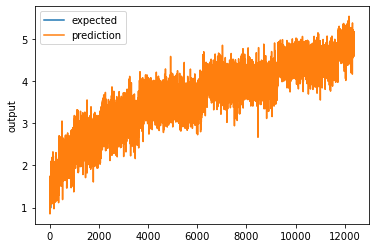


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 100 -> hidden: 3
Final score (RMSE): 0.2527991831302643


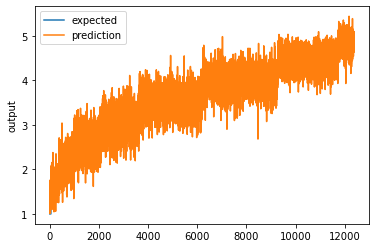


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 100 -> hidden: 1
Final score (RMSE): 0.2541428804397583


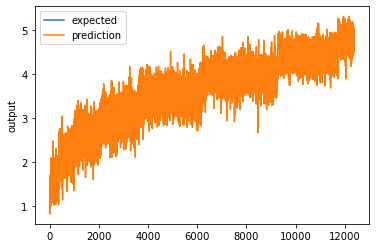


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 50 -> hidden: 100
Final score (RMSE): 0.25021857023239136


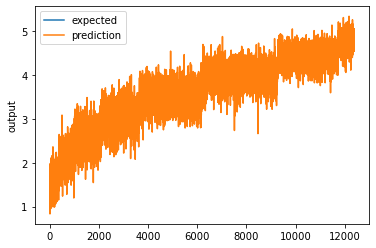


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 50 -> hidden: 50
Final score (RMSE): 0.2516820430755615


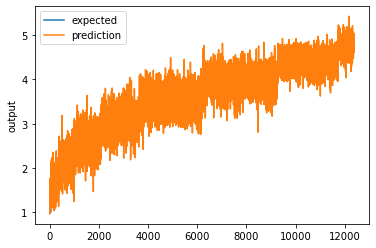


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 50 -> hidden: 25
Final score (RMSE): 0.2528510093688965


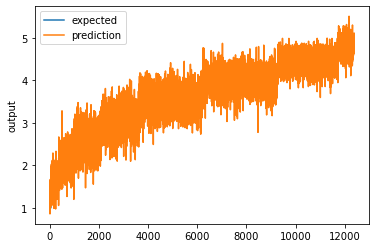


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 50 -> hidden: 12
Final score (RMSE): 0.2526407837867737


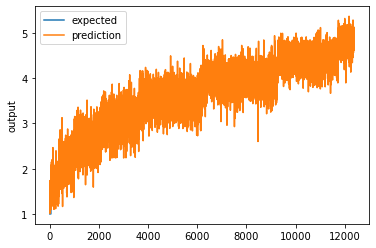


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 50 -> hidden: 6
Final score (RMSE): 0.2523673474788666


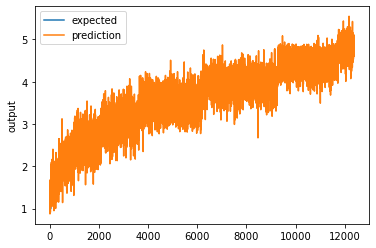


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 50 -> hidden: 3
Final score (RMSE): 0.2528453767299652


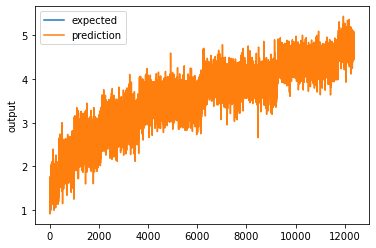


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 50 -> hidden: 1
Final score (RMSE): 0.25611576437950134


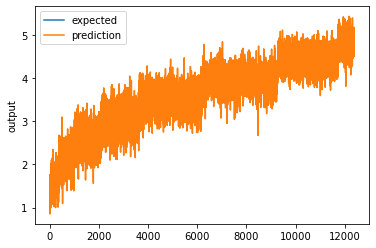


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 25 -> hidden: 100
Final score (RMSE): 0.2510520815849304


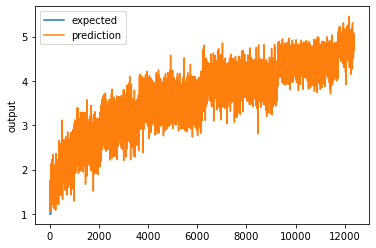


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 25 -> hidden: 50
Final score (RMSE): 0.25080418586730957


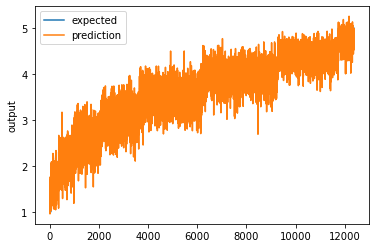


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 25 -> hidden: 25
Final score (RMSE): 0.2518899440765381


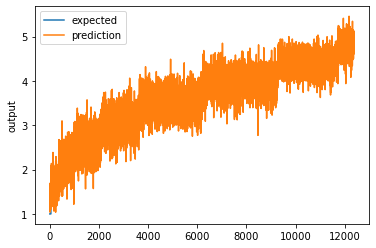


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 25 -> hidden: 12
Final score (RMSE): 0.25258100032806396


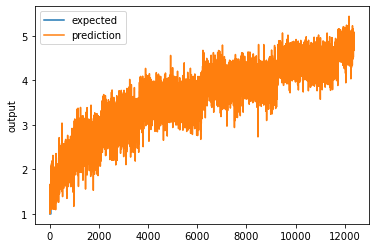


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 25 -> hidden: 6
Final score (RMSE): 0.2555908262729645


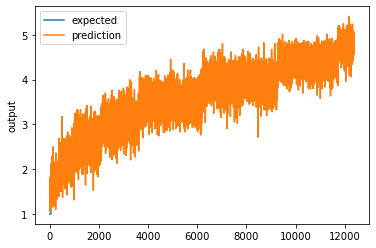


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 25 -> hidden: 3
Final score (RMSE): 0.25569307804107666


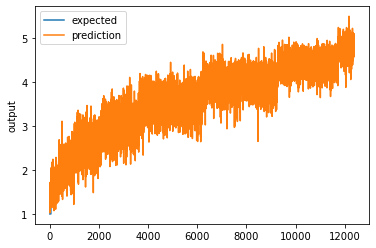


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 25 -> hidden: 1
Final score (RMSE): 0.25766700506210327


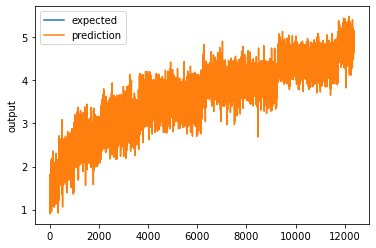


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 12 -> hidden: 100
Final score (RMSE): 0.2510700225830078


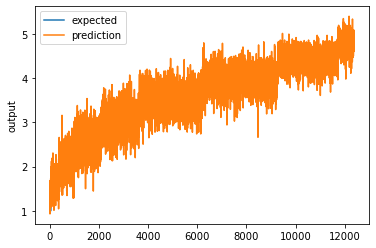


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 12 -> hidden: 50
Final score (RMSE): 0.2509293556213379


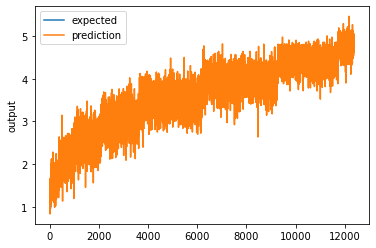


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 12 -> hidden: 25
Final score (RMSE): 0.25065121054649353


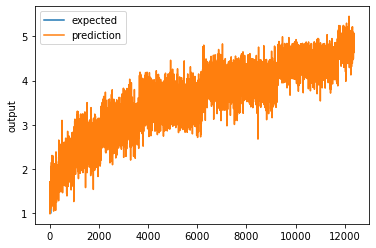


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 12 -> hidden: 12
Final score (RMSE): 0.2567150294780731


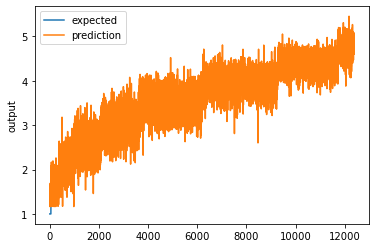


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 12 -> hidden: 6
Final score (RMSE): 0.2547314167022705


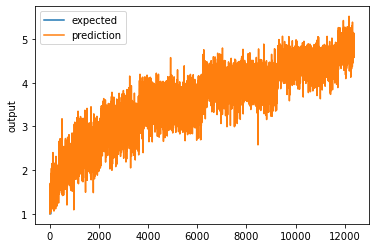


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 12 -> hidden: 3
Final score (RMSE): 0.2819638252258301


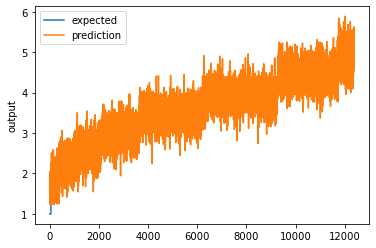


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 12 -> hidden: 1
Final score (RMSE): 0.2647978961467743


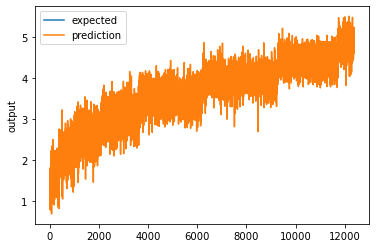


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 6 -> hidden: 100
Final score (RMSE): 0.2507206201553345


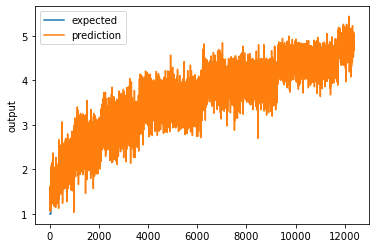


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 6 -> hidden: 50
Final score (RMSE): 0.2513677179813385


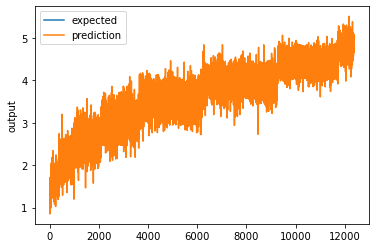


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 6 -> hidden: 25
Final score (RMSE): 0.2527819573879242


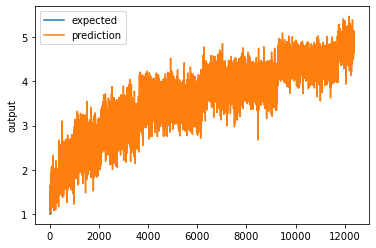


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 6 -> hidden: 12
Final score (RMSE): 0.2550972104072571


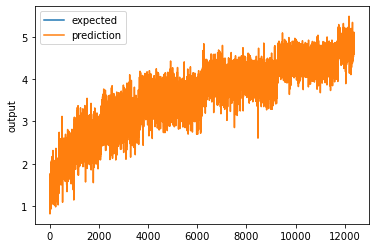


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 6 -> hidden: 6
Final score (RMSE): 0.2553282082080841


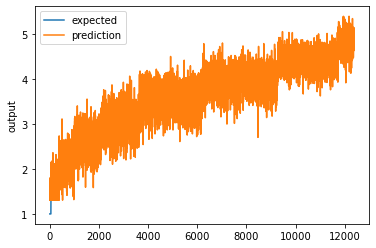


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 6 -> hidden: 3
Final score (RMSE): 0.2650396227836609


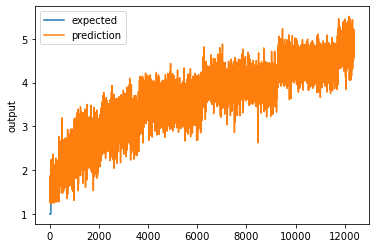


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 6 -> hidden: 1
Final score (RMSE): 0.2818334996700287


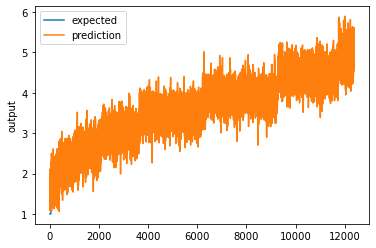


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 3 -> hidden: 100
Final score (RMSE): 0.2530895173549652


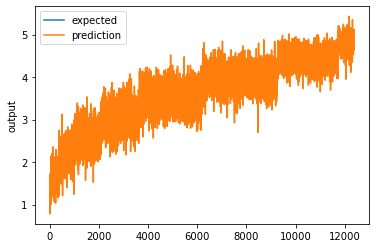


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 3 -> hidden: 50
Final score (RMSE): 0.2525363564491272


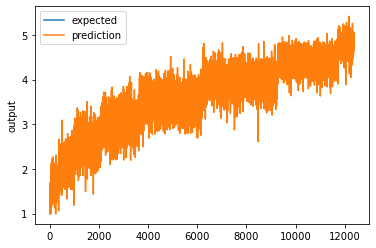


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 3 -> hidden: 25
Final score (RMSE): 0.25445324182510376


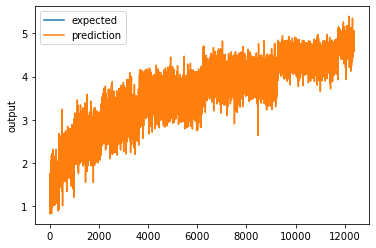


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 3 -> hidden: 12
Final score (RMSE): 0.255741685628891


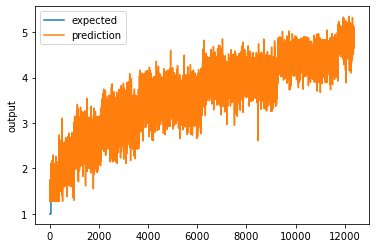


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 3 -> hidden: 6
Final score (RMSE): 0.2579909563064575


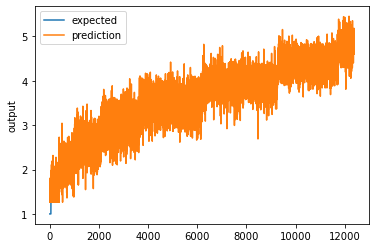


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 3 -> hidden: 3
Final score (RMSE): 0.2882145345211029


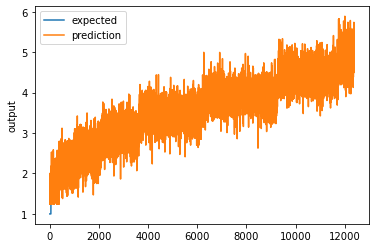


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 3 -> hidden: 1
Final score (RMSE): 0.28789272904396057


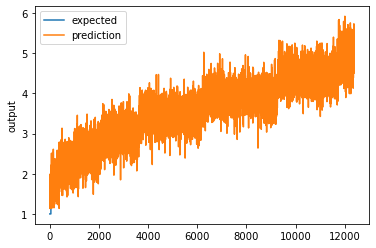


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 1 -> hidden: 100
Final score (RMSE): 0.27518659830093384


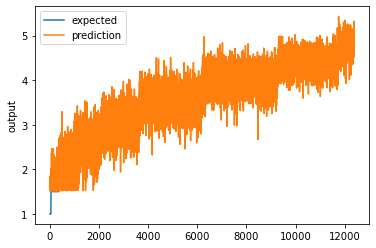


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 1 -> hidden: 50
Final score (RMSE): 0.2766033113002777


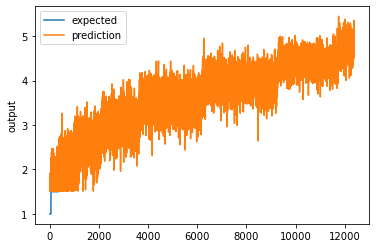


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 1 -> hidden: 25
Final score (RMSE): 0.2889244258403778


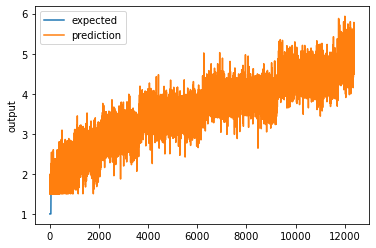


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 1 -> hidden: 12
Final score (RMSE): 0.2761935591697693


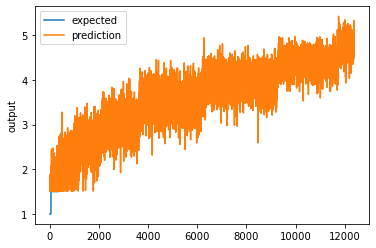


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 1 -> hidden: 6
Final score (RMSE): 0.2763255834579468


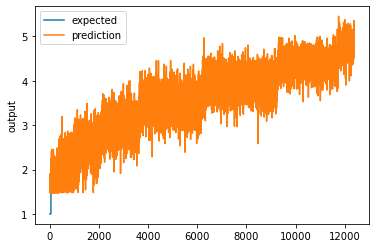


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 1 -> hidden: 3
Final score (RMSE): 0.2891346216201782


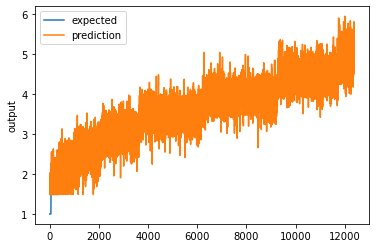


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Neuron Capacities: input: 1 -> hidden: 1
Final score (RMSE): 0.2885925769805908


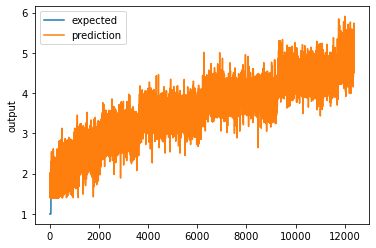

In [87]:
neuron_capacity_result = []
for x in capacity_list:
    neuron_capacity_result.append(neuron_capacity_test(x[0], x[1], concatenated_matrix_df))

In [88]:
neuron_capacity_result

[((100, 100), 0.2512577),
 ((100, 50), 0.25252208),
 ((100, 25), 0.25141558),
 ((100, 12), 0.2536633),
 ((100, 6), 0.2523024),
 ((100, 3), 0.25279918),
 ((100, 1), 0.25414288),
 ((50, 100), 0.25021857),
 ((50, 50), 0.25168204),
 ((50, 25), 0.252851),
 ((50, 12), 0.25264078),
 ((50, 6), 0.25236735),
 ((50, 3), 0.25284538),
 ((50, 1), 0.25611576),
 ((25, 100), 0.25105208),
 ((25, 50), 0.2508042),
 ((25, 25), 0.25188994),
 ((25, 12), 0.252581),
 ((25, 6), 0.25559083),
 ((25, 3), 0.25569308),
 ((25, 1), 0.257667),
 ((12, 100), 0.25107002),
 ((12, 50), 0.25092936),
 ((12, 25), 0.2506512),
 ((12, 12), 0.25671503),
 ((12, 6), 0.25473142),
 ((12, 3), 0.28196383),
 ((12, 1), 0.2647979),
 ((6, 100), 0.25072062),
 ((6, 50), 0.25136772),
 ((6, 25), 0.25278196),
 ((6, 12), 0.2550972),
 ((6, 6), 0.2553282),
 ((6, 3), 0.26503962),
 ((6, 1), 0.2818335),
 ((3, 100), 0.25308952),
 ((3, 50), 0.25253636),
 ((3, 25), 0.25445324),
 ((3, 12), 0.2557417),
 ((3, 6), 0.25799096),
 ((3, 3), 0.28821453),
 ((3, 1)

# 3) Increasing Layers

In [102]:
def layer_test(input_capacity, hidden_capacity, hidden2_capacity, layer_increase, df):
    # Defining model checkpoint outside of the loop
    checkpointer = ModelCheckpoint(filepath='dnn/best_weights.hdf5', verbose=0, save_best_only=True) # save best model
    
    x,y = to_xy(df, "stars_rating")
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

    for i in range(5):
        print()
        print("Iteration: ", i)

        # Building neural network
        model_sequential = Sequential()
        model_sequential.add(Dense(input_capacity, input_dim=x.shape[1], activation='relu')) # Input layer
        model_sequential.add(Dense(hidden_capacity, activation='relu')) # Hidden layer 1
        for i in range(layer_increase):
            model_sequential.add(Dense(hidden2_capacity, activation='relu')) # Hidden layer 2
            
        model_sequential.add(Dense(1, activation='relu')) # Output layer

        # If this were classification, we'd use a softmax activation
        model_sequential.compile(loss='mean_squared_error', optimizer='adam')

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
        # Patience = number of epochs with no improvements which training will be stopped.

        model_sequential.fit(x_train, y_train, validation_data=(x_test,y_test),
                             batch_size=32, callbacks=[monitor, checkpointer], verbose=0, epochs=100)

        
    model_sequential.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    prediction = model_sequential.predict(x_test)

    # Measuring RMSE
    RMSE_score = np.sqrt(metrics.mean_squared_error(prediction, y_test))
    print("Hidden layers increased by: {}".format(layer_increase))
    print("Neuron Capacities: input: {} -> hidden: {} -> hidden2: {}".format(input_capacity, hidden_capacity, hidden2_capacity))
    print("Final score (RMSE): {}".format(RMSE_score))
    # Plot the lift chart
    # Sort set to true to see how our model predicts it from least to greatest
    chart_regression(prediction.flatten(),y_test, sort=True)

    return ((input_capacity, hidden_capacity, hidden2_capacity), RMSE_score)
    


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Hidden layers increased by: 0
Neuron Capacities: input: 10 -> hidden: 15 -> hidden2: 5
Final score (RMSE): 0.25214511156082153


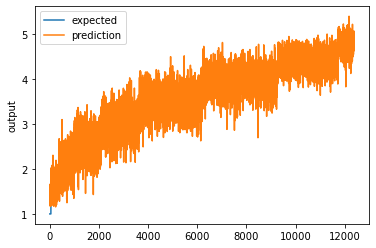


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Hidden layers increased by: 1
Neuron Capacities: input: 10 -> hidden: 15 -> hidden2: 5
Final score (RMSE): 0.2548545002937317


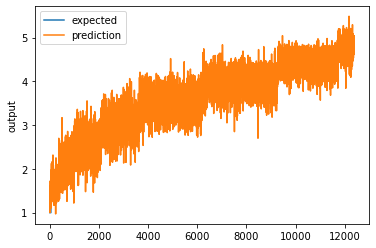


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Hidden layers increased by: 2
Neuron Capacities: input: 10 -> hidden: 15 -> hidden2: 5
Final score (RMSE): 0.2527224123477936


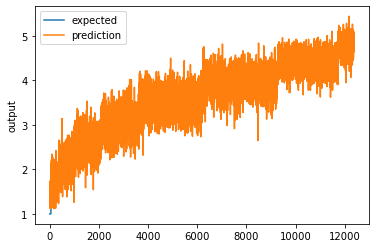


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Hidden layers increased by: 3
Neuron Capacities: input: 10 -> hidden: 15 -> hidden2: 5
Final score (RMSE): 0.2526319622993469


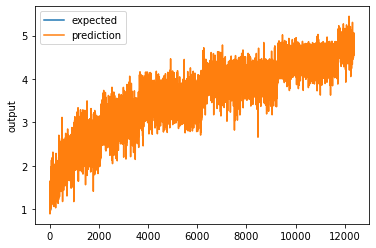

In [103]:
# For the sake of time, I will conduct only a few tests.
layer_testing_list = []
layer_testing_list.append(layer_test(10, 15, 5, 0, concatenated_matrix_df))
layer_testing_list.append(layer_test(10, 15, 5, 1, concatenated_matrix_df))
layer_testing_list.append(layer_test(10, 15, 5, 2, concatenated_matrix_df))
layer_testing_list.append(layer_test(10, 15, 5, 3, concatenated_matrix_df))

In [104]:
layer_testing_list

[((10, 15, 5), 0.2521451),
 ((10, 15, 5), 0.2548545),
 ((10, 15, 5), 0.2527224),
 ((10, 15, 5), 0.25263196)]

## Maybe it's overtraining? Must be learning rate and batch sizes.

# 4) Increasing batch size

In [114]:
def batch_test(size_of_batch, df):
    # Defining model checkpoint outside of the loop
    checkpointer = ModelCheckpoint(filepath='dnn/best_weights.hdf5', verbose=0, save_best_only=True) # save best model
    
    x,y = to_xy(df, "stars_rating")
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

    for i in range(5):
        print()
        print("Iteration: ", i)

        # Building neural network
        model_sequential = Sequential()
        model_sequential.add(Dense(5, input_dim=x.shape[1], activation='relu')) # Input layer
        model_sequential.add(Dense(10, activation='relu')) # Hidden layer 1
            
        model_sequential.add(Dense(1, activation='relu')) # Output layer

        # custom_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        # If this were classification, we'd use a softmax activation
        model_sequential.compile(loss='mean_squared_error', optimizer='adam')

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
        # Patience = number of epochs with no improvements which training will be stopped.

        model_sequential.fit(x_train, y_train, validation_data=(x_test,y_test),
                             batch_size=size_of_batch, callbacks=[monitor, checkpointer], verbose=0, epochs=100)

        
    model_sequential.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    prediction = model_sequential.predict(x_test)

    # Measuring RMSE
    RMSE_score = np.sqrt(metrics.mean_squared_error(prediction, y_test))
    print("Batch size: {}".format(size_of_batch))
    print("Final score (RMSE): {}".format(RMSE_score))
    # Plot the lift chart
    # Sort set to true to see how our model predicts it from least to greatest
    chart_regression(prediction.flatten(),y_test, sort=True)

    return (size_of_batch, RMSE_score)
    


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Batch size: 128
Final score (RMSE): 0.2566361129283905


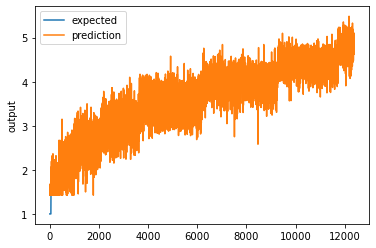


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Batch size: 64
Final score (RMSE): 0.25865575671195984


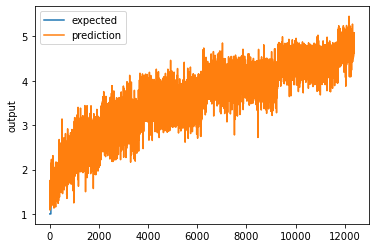


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Batch size: 32
Final score (RMSE): 0.2546360492706299


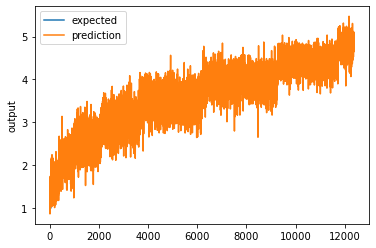


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Batch size: 16
Final score (RMSE): 0.25446024537086487


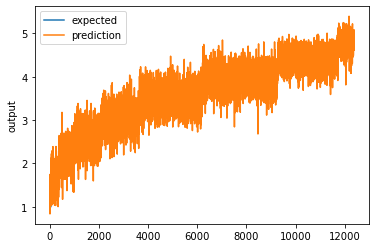


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Batch size: 8
Final score (RMSE): 0.2545589506626129


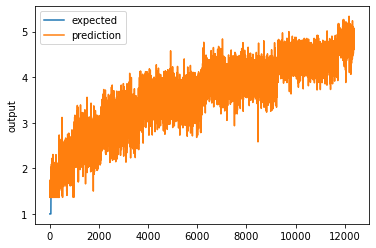

In [110]:
batch_test_list = []
batch_test_list.append(batch_test(128, concatenated_matrix_df))
batch_test_list.append(batch_test(64, concatenated_matrix_df))
batch_test_list.append(batch_test(32, concatenated_matrix_df))
batch_test_list.append(batch_test(16, concatenated_matrix_df))
batch_test_list.append(batch_test(8, concatenated_matrix_df))


In [111]:
batch_test_list

[(128, 0.2566361),
 (64, 0.25865576),
 (32, 0.25463605),
 (16, 0.25446025),
 (8, 0.25455895)]

# 5) Learning rate with Adam

In [119]:
def lr_test(learning_rate, df):
    # Defining model checkpoint outside of the loop
    checkpointer = ModelCheckpoint(filepath='dnn/best_weights.hdf5', verbose=0, save_best_only=True) # save best model
    
    x,y = to_xy(df, "stars_rating")
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

    for i in range(5):
        print()
        print("Iteration: ", i)

        # Building neural network
        model_sequential = Sequential()
        model_sequential.add(Dense(5, input_dim=x.shape[1], activation='relu')) # Input layer
        model_sequential.add(Dense(10, activation='relu')) # Hidden layer 1
            
        model_sequential.add(Dense(1, activation='relu')) # Output layer

        custom_adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        # If this were classification, we'd use a softmax activation
        model_sequential.compile(loss='mean_squared_error', optimizer=custom_adam)

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
        # Patience = number of epochs with no improvements which training will be stopped.

        model_sequential.fit(x_train, y_train, validation_data=(x_test,y_test),
                             batch_size=32, callbacks=[monitor, checkpointer], verbose=0, epochs=100)

        
    model_sequential.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    prediction = model_sequential.predict(x_test)

    # Measuring RMSE
    RMSE_score = np.sqrt(metrics.mean_squared_error(prediction, y_test))
    print("Learning rate for adam: {}".format(learning_rate))
    print("Final score (RMSE): {}".format(RMSE_score))
    # Plot the lift chart
    # Sort set to true to see how our model predicts it from least to greatest
    chart_regression(prediction.flatten(),y_test, sort=True)

    return (learning_rate, RMSE_score)
    


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Learning rate for adam: 1.0
Final score (RMSE): 3.7128679752349854


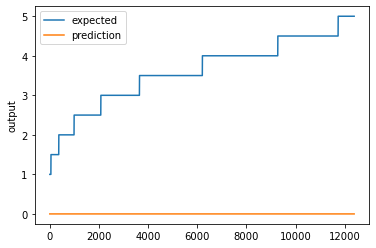


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Learning rate for adam: 0.1
Final score (RMSE): 0.270391583442688


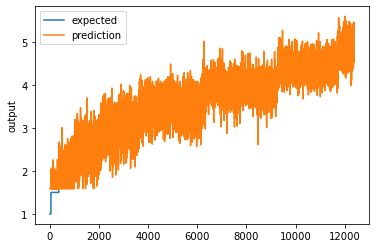


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Learning rate for adam: 0.01
Final score (RMSE): 0.25521644949913025


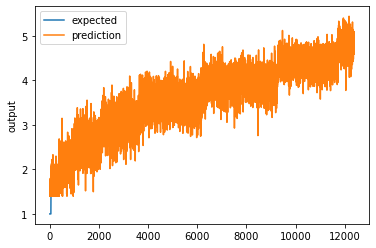


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Learning rate for adam: 0.001
Final score (RMSE): 0.2544954717159271


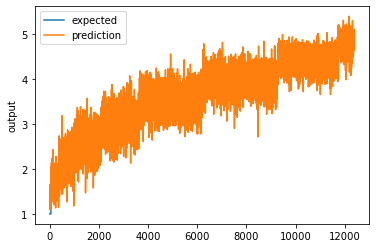


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Learning rate for adam: 0.0001
Final score (RMSE): 0.26169729232788086


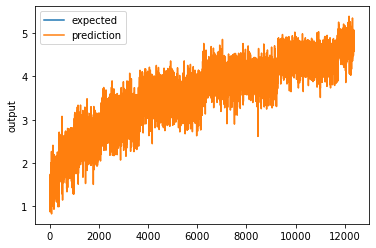

In [120]:
lr_list = []
lr_list.append(lr_test(1.0, concatenated_matrix_df))
lr_list.append(lr_test(0.1, concatenated_matrix_df))
lr_list.append(lr_test(0.01, concatenated_matrix_df))
lr_list.append(lr_test(0.001, concatenated_matrix_df))
lr_list.append(lr_test(0.0001, concatenated_matrix_df))

In [121]:
lr_list

[(1.0, 3.712868),
 (0.1, 0.27039158),
 (0.01, 0.25521645),
 (0.001, 0.25449547),
 (0.0001, 0.2616973)]

# 6) Learning rate with SGD

In [122]:
def sgd_lr_test(learning_rate, df):
    # Defining model checkpoint outside of the loop
    checkpointer = ModelCheckpoint(filepath='dnn/best_weights.hdf5', verbose=0, save_best_only=True) # save best model
    
    x,y = to_xy(df, "stars_rating")
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

    for i in range(5):
        print()
        print("Iteration: ", i)

        # Building neural network
        model_sequential = Sequential()
        model_sequential.add(Dense(5, input_dim=x.shape[1], activation='relu')) # Input layer
        model_sequential.add(Dense(10, activation='relu')) # Hidden layer 1
            
        model_sequential.add(Dense(1, activation='relu')) # Output layer
        
        custom_sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        # If this were classification, we'd use a softmax activation
        model_sequential.compile(loss='mean_squared_error', optimizer=custom_sgd)

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
        # Patience = number of epochs with no improvements which training will be stopped.

        model_sequential.fit(x_train, y_train, validation_data=(x_test,y_test),
                             batch_size=32, callbacks=[monitor, checkpointer], verbose=0, epochs=100)

        
    model_sequential.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    prediction = model_sequential.predict(x_test)

    # Measuring RMSE
    RMSE_score = np.sqrt(metrics.mean_squared_error(prediction, y_test))
    print("Learning rate for sgd: {}".format(learning_rate))
    print("Final score (RMSE): {}".format(RMSE_score))
    # Plot the lift chart
    # Sort set to true to see how our model predicts it from least to greatest
    chart_regression(prediction.flatten(),y_test, sort=True)

    return (learning_rate, RMSE_score)
    


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Learning rate for sgd: 1.0
Final score (RMSE): 0.25821956992149353


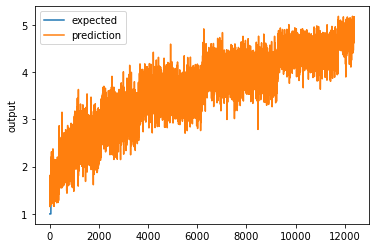


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Learning rate for sgd: 0.1
Final score (RMSE): 0.2601304352283478


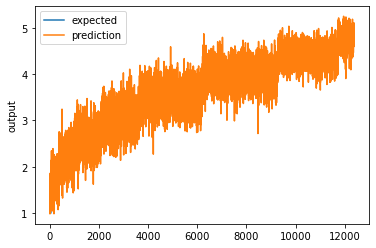


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Learning rate for sgd: 0.01
Final score (RMSE): 0.26363271474838257


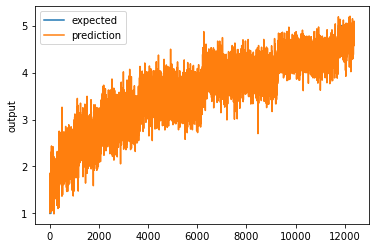


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Learning rate for sgd: 0.001
Final score (RMSE): 0.25858813524246216


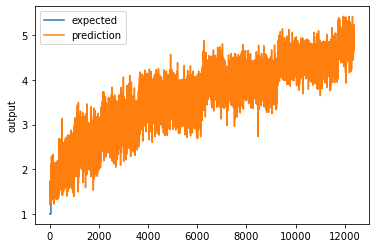


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Learning rate for sgd: 0.0001
Final score (RMSE): 0.257457971572876


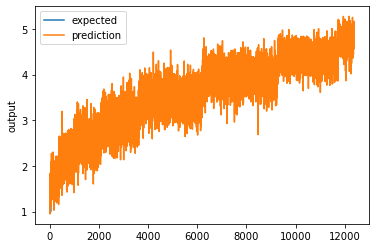

In [123]:
sgd_lr_list = []
sgd_lr_list.append(sgd_lr_test(1.0, concatenated_matrix_df))
sgd_lr_list.append(sgd_lr_test(0.1, concatenated_matrix_df))
sgd_lr_list.append(sgd_lr_test(0.01, concatenated_matrix_df))
sgd_lr_list.append(sgd_lr_test(0.001, concatenated_matrix_df))
sgd_lr_list.append(sgd_lr_test(0.0001, concatenated_matrix_df))


In [124]:
sgd_lr_list

[(1.0, 0.25821957),
 (0.1, 0.26013044),
 (0.01, 0.2636327),
 (0.001, 0.25858814),
 (0.0001, 0.25745797)]

# 7) Best Model?

In [203]:
def best_model_test(learning_rate, size_of_batch, df):
    # Defining model checkpoint outside of the loop
    checkpointer = ModelCheckpoint(filepath='dnn/best_weights.hdf5', verbose=0, save_best_only=True) # save best model
    
    x,y = to_xy(df, "stars_rating")
    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

    for i in range(5):
        print()
        print("Iteration: ", i)

        # Building neural network
        model_sequential = Sequential()
        model_sequential.add(Dense(10, input_dim=x.shape[1], activation='relu')) # Input layer
        model_sequential.add(Dense(25, activation='relu')) # Hidden layer 1
        model_sequential.add(Dense(10, activation='relu')) # Hidden layer 1
            
        model_sequential.add(Dense(1, activation='relu')) # Output layer
        
        # custom_sgd = optimizers.SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
        custom_adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        # If this were classification, we'd use a softmax activation
        model_sequential.compile(loss='mean_squared_error', optimizer=custom_adam)

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
        # Patience = number of epochs with no improvements which training will be stopped.

        model_sequential.fit(x_train, y_train, validation_data=(x_test,y_test),
                             batch_size=size_of_batch, callbacks=[monitor, checkpointer], verbose=0, epochs=100)

        
    model_sequential.load_weights('dnn/best_weights.hdf5') # load weights from best model
    
    prediction = model_sequential.predict(x_test)

    # Measuring RMSE
    RMSE_score = np.sqrt(metrics.mean_squared_error(prediction, y_test))
    print("Learning rate for adam: {}".format(learning_rate))
    print("Batch Size: {}".format(size_of_batch))
    print("Final score (RMSE): {}".format(RMSE_score))
    # Plot the lift chart
    # Sort set to true to see how our model predicts it from least to greatest
    chart_regression(prediction.flatten(),y_test, sort=True)

    return model_sequential
    


Iteration:  0

Iteration:  1

Iteration:  2

Iteration:  3

Iteration:  4
Learning rate for adam: 0.01
Batch Size: 32
Final score (RMSE): 0.2537679374217987


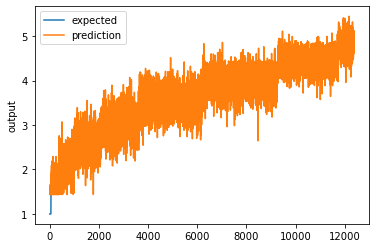

In [204]:
best_model = best_model_test(0.01, 32, concatenated_matrix_df)

# 3-5 Businesses to test my model on

In [187]:
merged_dfs_before

,text,name,stars,review_count,categories
0,Ate here for the 1st time on Saturday 08/07/20...,Frankie's Raw Bar,4.5,-0.402919,"Seafood, Restaurants, Latin American, Food, Fo..."
1,"Took me for 40 bucks through grubhub, no call ...",The Original Italian Pie,3.0,-0.385956,"Food, Restaurants, Italian"
2,I loved this!!!! I was set up on a blind date ...,Will You Escape?,5.0,-0.374648,"Active Life, Challenge Courses, Escape Games"
3,What a great neighborhood place to wine it up....,Traveling Corks,4.5,-0.408573,"Wine Bars, Nightlife, Bars"
4,This is my go to car wash establishment. Today...,Victory Car Wash,3.5,-0.312452,"Car Wash, Automotive"
...,...,...,...,...,...
61914,Last night was my first time over at F&M on Tc...,F & M Patio Bar,3.0,-0.052359,"Food, American (Traditional), Nightlife, Resta..."
61915,I went here for the HydroFacial. I have gotten...,Eden Medical Spa,1.5,-0.414227,"Laser Hair Removal, Beauty & Spas, Skin Care, ..."
61916,I recently stopped here for lunch.I had debs c...,Ruby's Kitchen,3.0,-0.402919,"Breakfast & Brunch, Burgers, American (Traditi..."
61917,Went in for lunch and tried the jerk chicken a...,Taste of the Islands,4.0,-0.272873,"Caribbean, Restaurants"


In [165]:
merged_dfs_before.drop(['business_id', 'address', 'city', 'state',
                 'postal_code','latitude', 'longitude',
                 'is_open', 'attributes', 'hours'], axis=1, inplace=True)
encode_numeric_zscore(merged_dfs_before, 'review_count')

In [169]:
merged_dfs_before[30000:31000]

,text,name,stars,review_count,categories
30000,I've been going to The Tea Girl for years and ...,The Tea Girl,4.5,68,"Food, Coffee & Tea"
30001,I went to Hydrovolve because initially my ears...,Hydravolve Studios,5.0,23,"Piercing, Tattoo, Beauty & Spas"
30002,"Yummy, yummy Chai that tastes exactly like whe...",Chaat and Chai,4.5,21,"Food Stands, Indian, Restaurants"
30003,This place looks great!!! I went on the secon...,GattiTown,3.5,22,"Food, Desserts, Pizza, Restaurants, Buffets"
30004,First visit and the food was amazing. I had a ...,Bocelli Restaurant,4.5,119,"Pizza, Desserts, Caterers, Seafood, Restaurant..."
...,...,...,...,...,...
30995,It was my first time here and I was really imp...,Rose Bar Tampa,4.0,62,"American (New), Seafood, Burgers, Breakfast & ..."
30996,I came to New Orleans for a few days and decid...,New Orleans Native Tours,4.5,25,"Hotels & Travel, Tours, Historical Tours, Bus ..."
30997,"Two Sunday nights in a row, we have bypassed o...",Jet's Pizza,3.5,41,"Food Delivery Services, Salad, Food, Restauran..."
30998,Been a patient here for quite a while now. The...,Downtown Dental,4.5,53,"Cosmetic Dentists, General Dentistry, Health &..."


In [223]:
VictoryCarWash = merged_dfs_before.loc[4]
DunkinDonuts = merged_dfs_before.loc[61918]
EdenMedicalSpa = merged_dfs_before.loc[61915]
WernerCoach = merged_dfs_before.loc[997]
DowntownDental = merged_dfs_before.loc[30998]

records_list = []
records_list.append(VictoryCarWash)
records_list.append(DunkinDonuts)
records_list.append(EdenMedicalSpa)
records_list.append(WernerCoach)
records_list.append(DowntownDental)

final_test_dataframe = pd.DataFrame.from_records(records_list)
final_test_dataframe

copy_final_df = final_test_dataframe.copy()

In [224]:
# TF-IDF Vectorizer : Transforms text into a 'sparse matrix' where rows are text and columns are words, values are the TF-IDF values.
vectorizer = sk_text.TfidfVectorizer(min_df=1, max_features=1000)

final_matrix = vectorizer.fit_transform(final_test_dataframe['text'])

print(type(final_matrix))
final_matrix = final_matrix.toarray()
print(type(final_matrix)) # Matrix converted successfully!

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


In [225]:
final_matrix_df = pd.DataFrame(final_matrix, columns = vectorizer.get_feature_names())
final_test_dataframe.drop(['text', 'name', 'categories'], axis=1, inplace=True)
final_test_dataframe = final_test_dataframe.rename(columns = {'stars' : 'stars_rating'})
final_concatenated_matrix_df = pd.concat([final_matrix_df, final_test_dataframe], axis=1)

In [226]:
final_concatenated_matrix_df

,00,10,15,19,20,21,22,30,50,99,...,wrong,yeah,year,years,yet,you,your,zero,stars_rating,review_count
0,0.000000,0.010042,0.019895,0.000000,0.002831,0.014381,0.009587,0.000000,0.000000,0.000000,...,0.003347,0.000000,0.011937,0.000000,0.007958,0.082103,0.053791,0.023766,3.5,-0.312452
1,0.052207,0.005882,0.006993,0.031324,0.009951,0.000000,0.000000,0.000000,0.031324,0.016848,...,0.011765,0.016848,0.000000,0.000000,0.000000,0.109458,0.039803,0.000000,1.5,-0.368994
2,0.000000,0.000000,0.000000,0.000000,0.004439,0.007517,0.000000,0.015033,0.000000,0.007517,...,0.000000,0.007517,0.006239,0.015033,0.006239,0.106546,0.035515,0.000000,1.5,-0.414227
3,0.000000,0.004205,0.014995,0.000000,0.003556,0.000000,0.006021,0.018064,0.000000,0.000000,...,0.004205,0.000000,0.000000,0.000000,0.000000,0.039119,0.024894,0.000000,3.5,-0.397265
4,0.000000,0.002483,0.000000,0.000000,0.006300,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002483,0.000000,0.008855,0.032003,0.002952,0.111308,0.058804,0.000000,4.5,-0.238948


In [227]:
x,y = to_xy(final_concatenated_matrix_df, "stars_rating")

Final score (RMSE): 1.0655672550201416


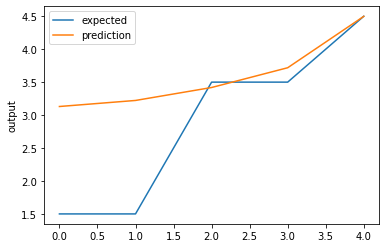

In [228]:
prediction = best_model.predict(x)

RMSE_score = np.sqrt(metrics.mean_squared_error(prediction, y))
print("Final score (RMSE): {}".format(RMSE_score))

chart_regression(prediction.flatten(),y, sort=True)

In [229]:
# print out prediction
df_y = pd.DataFrame(y, columns=['ground_truth'])
df_pred = pd.DataFrame(prediction, columns=['predicted'])
copy_final_df.drop(['text', 'stars', 'review_count'], axis=1, inplace=True)
result = pd.concat([df_y, df_pred], axis=1)
final_result = pd.concat([result, copy_final_df], axis=1)
final_result

,ground_truth,predicted,name,categories
0,3.5,3.418486,Victory Car Wash,"Car Wash, Automotive"
1,1.5,3.130205,Dunkin',"Food, Restaurants, Coffee & Tea, Donuts"
2,1.5,3.221978,Eden Medical Spa,"Laser Hair Removal, Beauty & Spas, Skin Care, ..."
3,3.5,3.718503,Werner Coach,"Bus Tours, Party Bus Rentals, Buses, Public Tr..."
4,4.5,4.498437,Downtown Dental,"Cosmetic Dentists, General Dentistry, Health &..."
